# INSY662 - Group Project - Predicting Airline Fares

### Problem Definition and Motivation



### Dataset Description 


### Initial Processing Steps

In [163]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re

# Load dataset in folder Data 
df = pd.read_csv('data/processed_data.csv')
df.head()

# keep only 20% of rows 
data = df.sample(frac=0.05, random_state=42)




In [164]:
# 1) Check data types 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205347 entries, 1042959 to 1887118
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   legId                              205347 non-null  object 
 1   searchDate                         205347 non-null  object 
 2   flightDate                         205347 non-null  object 
 3   startingAirport                    205347 non-null  object 
 4   destinationAirport                 205347 non-null  object 
 5   fareBasisCode                      205347 non-null  object 
 6   travelDuration                     205347 non-null  object 
 7   elapsedDays                        205347 non-null  int64  
 8   isBasicEconomy                     205347 non-null  bool   
 9   isRefundable                       205347 non-null  bool   
 10  isNonStop                          205347 non-null  bool   
 11  baseFare                           20

In [165]:
# Chekck missing values
data.isnull().sum()

legId                                    0
searchDate                               0
flightDate                               0
startingAirport                          0
destinationAirport                       0
fareBasisCode                            0
travelDuration                           0
elapsedDays                              0
isBasicEconomy                           0
isRefundable                             0
isNonStop                                0
baseFare                                 0
totalFare                                0
seatsRemaining                           0
totalTravelDistance                  15255
segmentsDepartureTimeEpochSeconds        0
segmentsDepartureTimeRaw                 0
segmentsArrivalTimeEpochSeconds          0
segmentsArrivalTimeRaw                   0
segmentsArrivalAirportCode               0
segmentsDepartureAirportCode             0
segmentsAirlineName                      0
segmentsAirlineCode                      0
segmentsEqu

In [166]:
# Missing value Ration
missing_ratio = data.isnull().sum() / len(data) * 100
missing_ratio = missing_ratio[missing_ratio > 0].sort_values(ascending=False)
missing_ratio

totalTravelDistance             7.428889
segmentsEquipmentDescription    1.905555
segmentsDistance                1.023633
dtype: float64

In [167]:
# ---------- Find dupplicates ----------------
dupplicates = data[data.duplicated()]
ratio = len(dupplicates) / len(data) * 100
print(f"There are {len(dupplicates)} out of {len(data)} rows, representing {ratio:.2f}%")

# Ratio is low, drop
data = data.drop_duplicates()
dupplicates = data[data.duplicated()]
ratio = len(dupplicates) / len(data) * 100
print(f"There are {len(dupplicates)} out of {len(data)} rows, representing {ratio:.2f}%")


There are 256 out of 205347 rows, representing 0.12%
There are 0 out of 205091 rows, representing 0.00%


#### Data Cleaning

In [168]:
# ------Drop unecessary segment columns---------
# Reasons: redundent information or not relevant to objective of analysis
unecessary_col = ['segmentsDepartureTimeEpochSeconds', 'segmentsArrivalTimeEpochSeconds', 'segmentsAirlineCode', 'segmentsEquipmentDescription']
data = data.drop(columns = unecessary_col)


In [169]:
# ------------- Clean/Split Segment Columns ---------------

# List segment columns
segments = [col for col in data.columns if "segment" in col.lower()]
segments

# Split columns per segment and drop original column
for col in segments:
    split_cols = data[col].str.split("||", expand=True, regex=False)
    split_cols = split_cols.dropna(axis = 1, how = "all")
    split_cols.columns = [f"{col}_{i+1}" for i in range(split_cols.shape[1])]
    data = pd.concat([data, split_cols], axis = 1)
    data = data.drop(columns = [col])

In [170]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205091 entries, 1042959 to 1887118
Data columns (total 55 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   legId                           205091 non-null  object 
 1   searchDate                      205091 non-null  object 
 2   flightDate                      205091 non-null  object 
 3   startingAirport                 205091 non-null  object 
 4   destinationAirport              205091 non-null  object 
 5   fareBasisCode                   205091 non-null  object 
 6   travelDuration                  205091 non-null  object 
 7   elapsedDays                     205091 non-null  int64  
 8   isBasicEconomy                  205091 non-null  bool   
 9   isRefundable                    205091 non-null  bool   
 10  isNonStop                       205091 non-null  bool   
 11  baseFare                        205091 non-null  float64
 12  totalFare     

In [171]:
# ------------ Correct Data Types of Segments ----------------

# List segment columns
segmentsTime_cols = [col for col in data.columns if "timeraw" in col.lower()]
for col in segmentsTime_cols:
    data[col] = pd.to_datetime(data[col], errors='coerce', utc=True)
for c in segmentsTime_cols:
    data[c] = data[c].dt.tz_localize(None)

segmentsNumerical_cols = [col for col in data.columns if "seconds" in col.lower() or "distance" in col.lower()]
for col in segmentsNumerical_cols:
    data[col] = pd.to_numeric(data[col], errors='coerce').astype('Int64')


In [172]:
# ---------Clean Other DataTypes----------------

# Transfrom data columns into correct data types
data['searchDate'] = pd.to_datetime(data['searchDate'])
data['flightDate'] = pd.to_datetime(data['flightDate'])

# Create new column for number of days between search date and flight date
data['date_diff'] = (data['flightDate'] - data['searchDate']).dt.days




In [173]:
#------------- Clean Travel Duration column --------------
def parse_travel_duration(s):
    if pd.isnull(s):
        return None
    match = re.match(r'PT(?:(\d+)H)?(?:(\d+)M)?', s)
    if not match:
        return None
    hours = int(match.group(1)) if match.group(1) else 0
    minutes = int(match.group(2)) if match.group(2) else 0
    return hours + minutes / 60

data['travelDuration_hours'] = data['travelDuration'].apply(parse_travel_duration)
data = data.drop(columns = 'travelDuration')





In [174]:
data['travelDuration_hours'] 

1042959    17.850000
1437841     2.683333
1067453    10.983333
198386     14.833333
2674967     8.716667
             ...    
2792471     8.066667
39596      12.566667
1117427     5.666667
3329802    15.050000
1887118     8.216667
Name: travelDuration_hours, Length: 205091, dtype: float64

In [175]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205091 entries, 1042959 to 1887118
Data columns (total 56 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   legId                           205091 non-null  object        
 1   searchDate                      205091 non-null  datetime64[ns]
 2   flightDate                      205091 non-null  datetime64[ns]
 3   startingAirport                 205091 non-null  object        
 4   destinationAirport              205091 non-null  object        
 5   fareBasisCode                   205091 non-null  object        
 6   elapsedDays                     205091 non-null  int64         
 7   isBasicEconomy                  205091 non-null  bool          
 8   isRefundable                    205091 non-null  bool          
 9   isNonStop                       205091 non-null  bool          
 10  baseFare                        205091 non-null  float

In [176]:
data.describe()

,searchDate,flightDate,elapsedDays,baseFare,totalFare,seatsRemaining,totalTravelDistance,segmentsDepartureTimeRaw_1,segmentsDepartureTimeRaw_2,segmentsDepartureTimeRaw_3,...,segmentsDurationInSeconds_3,segmentsDurationInSeconds_4,segmentsDurationInSeconds_5,segmentsDistance_1,segmentsDistance_2,segmentsDistance_3,segmentsDistance_4,segmentsDistance_5,date_diff,travelDuration_hours
count,205091,205091,205091.000000,205091.000000,205091.000000,205091.000000,189857.0,205091,149940,19518,...,19518.0,518.0,2.0,189857.0,136807.0,19036.0,518.0,2.0,205091.000000,205021.000000
mean,2022-07-13 21:37:43.254848,2022-08-09 17:48:12.150313472,0.149485,292.735894,340.451497,5.976601,1609.069184,2022-08-10 11:05:12.100872192,2022-08-12 00:56:29.672268800,2022-08-18 03:16:17.715954176,...,7355.699354,6345.289575,6240.0,900.262908,895.418736,641.844085,480.677606,499.5,26.840612,7.132755
min,2022-04-16 00:00:00,2022-04-17 00:00:00,0.000000,0.410000,19.590000,0.000000,89.0,2022-04-17 09:26:00,2022-04-17 12:00:00,2022-04-17 18:15:00,...,1200.0,2880.0,5220.0,67.0,31.0,31.0,90.0,327.0,1.000000,0.766667
25%,2022-06-05 00:00:00,2022-07-01 00:00:00,0.000000,159.000000,197.100000,4.000000,876.0,2022-07-02 00:32:00,2022-07-04 15:58:30,2022-07-14 10:53:45,...,5040.0,5400.0,5730.0,424.0,406.0,338.0,255.0,413.25,13.000000,4.350000
50%,2022-07-16 00:00:00,2022-08-14 00:00:00,0.000000,259.530000,303.700000,7.000000,1464.0,2022-08-15 01:50:00,2022-08-17 12:15:00,2022-08-24 23:50:00,...,6720.0,6330.0,6240.0,720.0,720.0,545.0,549.0,499.5,26.000000,6.816667
75%,2022-08-23 00:00:00,2022-09-18 00:00:00,0.000000,398.140000,452.700000,9.000000,2417.0,2022-09-18 13:45:00,2022-09-20 01:05:00,2022-09-24 22:13:00,...,8100.0,6720.0,6750.0,1193.0,1209.0,720.0,552.0,585.75,40.000000,9.433333
max,2022-10-05 00:00:00,2022-11-19 00:00:00,2.000000,4407.440000,4752.600000,10.000000,4498.0,2022-11-20 05:30:00,2022-11-20 13:16:00,2022-11-20 02:05:00,...,24360.0,19260.0,7260.0,2722.0,2722.0,2722.0,2516.0,672.0,60.000000,23.933333
std,NaN,NaN,0.356608,183.484098,196.363650,2.878256,857.232738,NaN,NaN,NaN,...,3256.59183,1752.200665,1442.497834,646.718788,633.915106,472.82985,282.49481,243.95184,16.314816,3.743439


In [177]:
# Question: Handling Outliers

### Exploratory Data Analysis (EDA) results

In [178]:
# Look at numerical relatioships with Total Fare

import seaborn as sns
import matplotlib.pyplot as plt

def num_plotter(data, target):

    num_cols = data.select_dtypes(include=["int", "float"]).columns

    for col in num_cols:
        if col == target:
            continue  

        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=col, y=target, data=data, alpha=0.3)
        plt.title(f"{col} vs {target}")
        plt.tight_layout()
        plt.show()


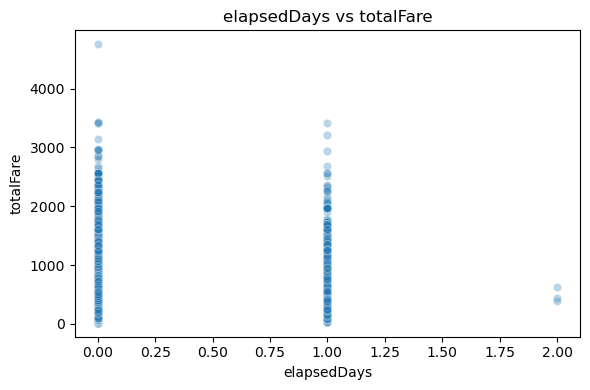

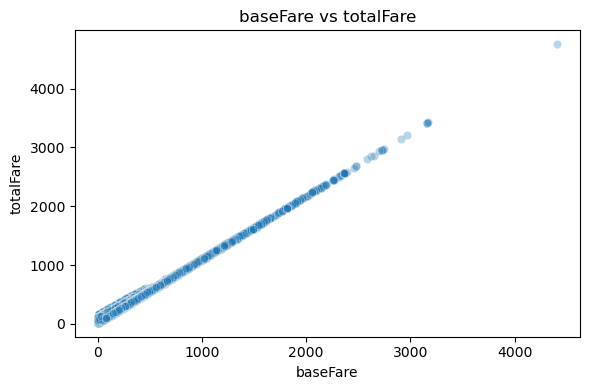

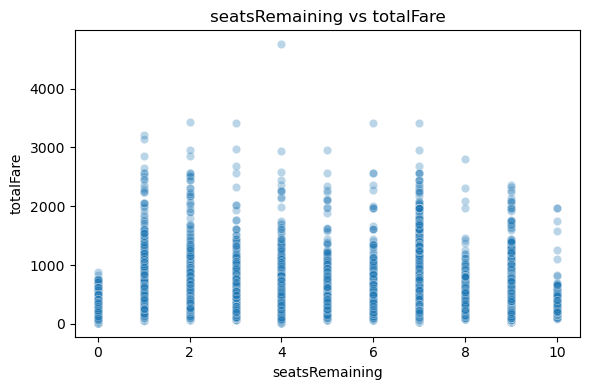

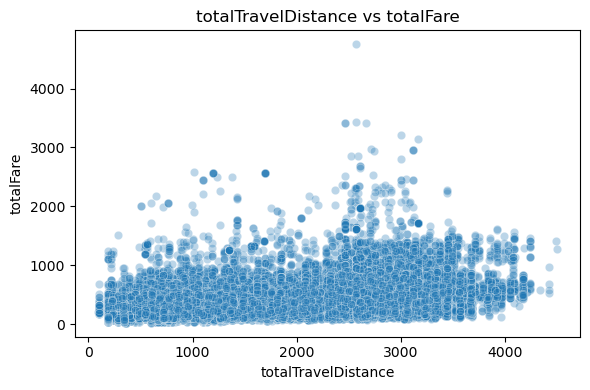

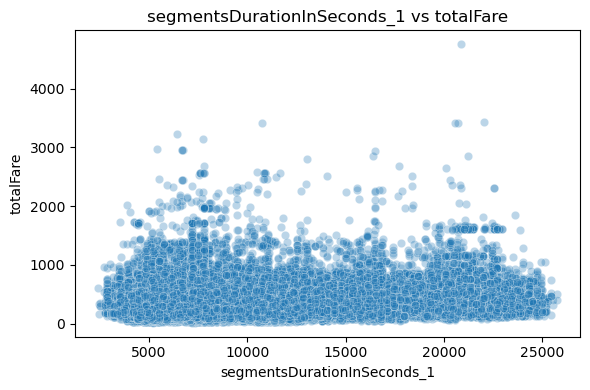

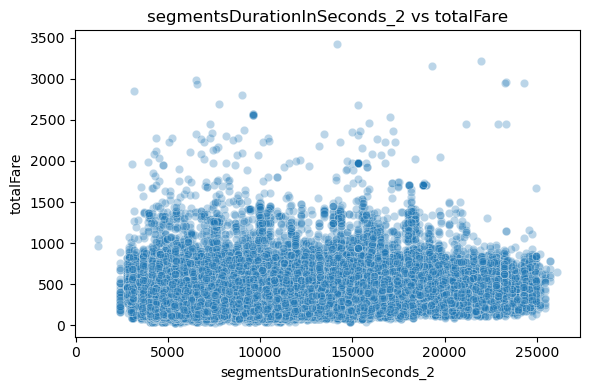

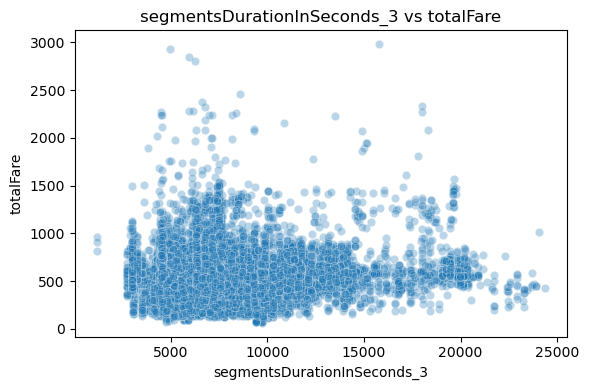

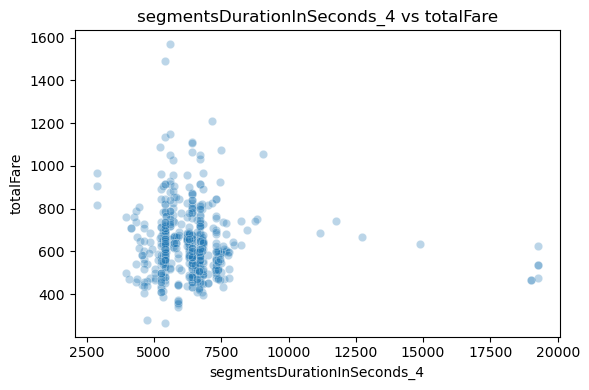

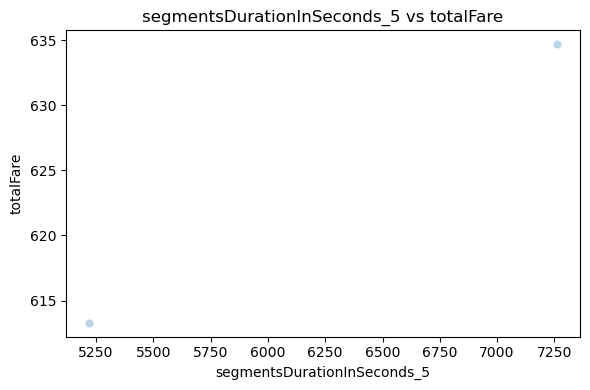

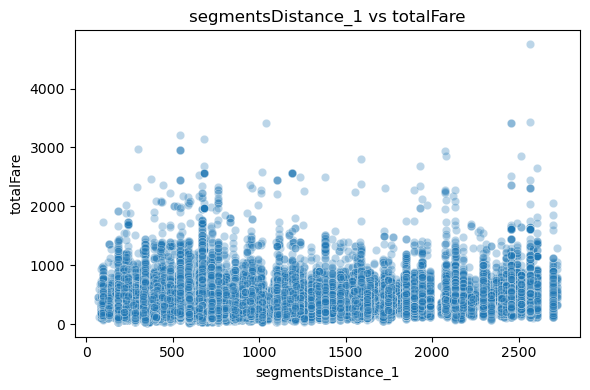

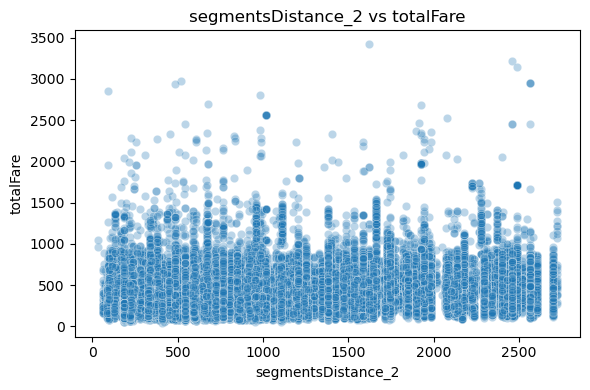

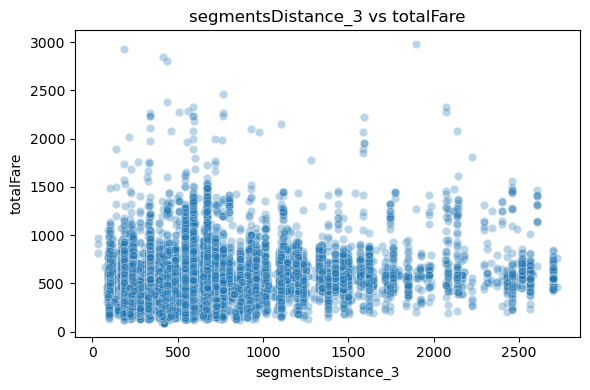

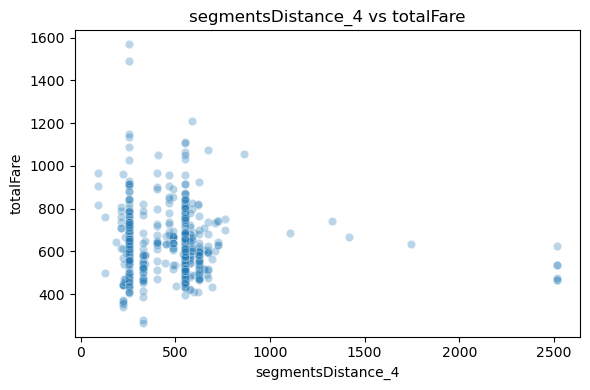

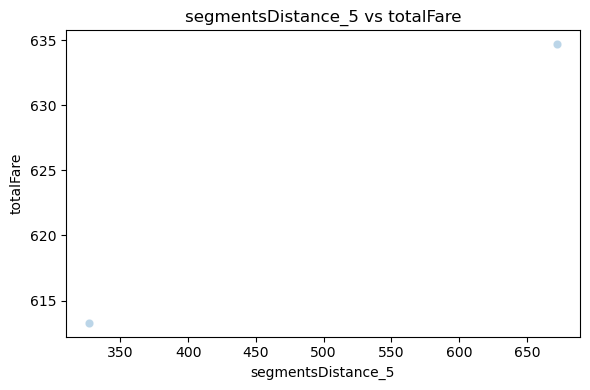

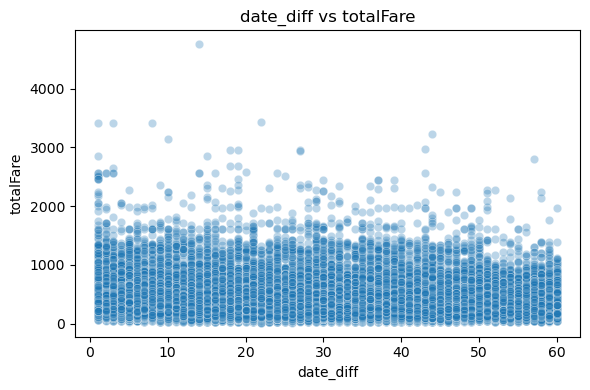

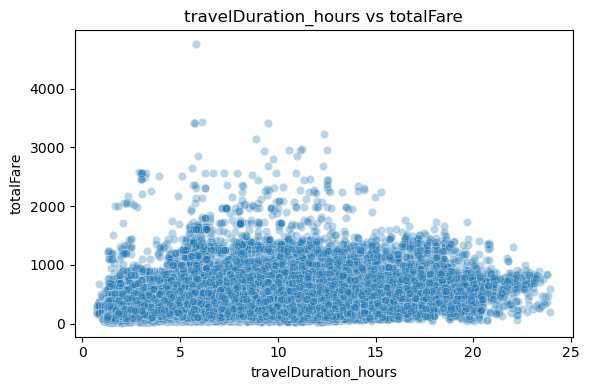

In [179]:
num_plotter(data, "totalFare")


In [180]:
# Look at categorical variable relationships with Total Fare
def cat_plotter(data, target, sample_size=100000):
    cat_cols = [
        'startingAirport',
        'destinationAirport'
    ]
    
    
    # 3. Plot
    for col in cat_cols:
        plt.figure(figsize=(8, 4))
        sns.barplot(
            data=(
                data
                .groupby(col, as_index=False)
                .agg({target: "mean"})
                .sort_values(by=target, ascending=False)
            ), 
            x=col, 
            y=target
        )
        plt.title(f"Average {target} by {col}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    

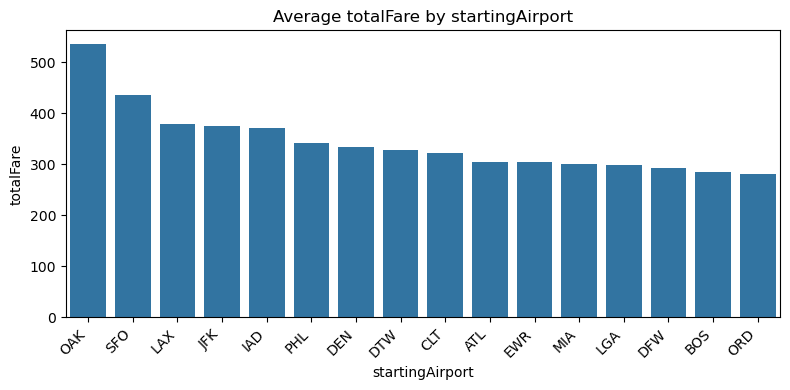

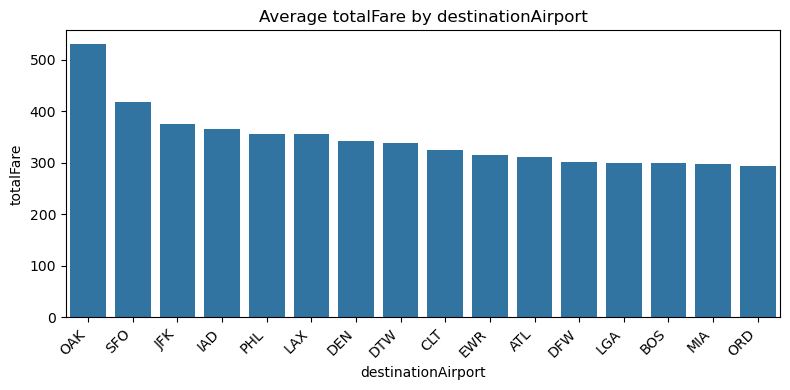

In [181]:
cat_plotter(data, "totalFare", sample_size=100000)


                      elapsedDays  baseFare  totalFare  seatsRemaining  \
elapsedDays              1.000000  0.135252   0.145732       -0.024762   
baseFare                 0.135252  1.000000   0.996711        0.059145   
totalFare                0.145732  0.996711   1.000000        0.020617   
seatsRemaining          -0.024762  0.059145   0.020617        1.000000   
totalTravelDistance      0.294933  0.486401   0.493158       -0.054751   
date_diff                0.005750 -0.059612  -0.058875        0.135607   
travelDuration_hours     0.382040  0.390617   0.427180       -0.149508   

                      totalTravelDistance  date_diff  travelDuration_hours  
elapsedDays                      0.294933   0.005750              0.382040  
baseFare                         0.486401  -0.059612              0.390617  
totalFare                        0.493158  -0.058875              0.427180  
seatsRemaining                  -0.054751   0.135607             -0.149508  
totalTravelDistance   

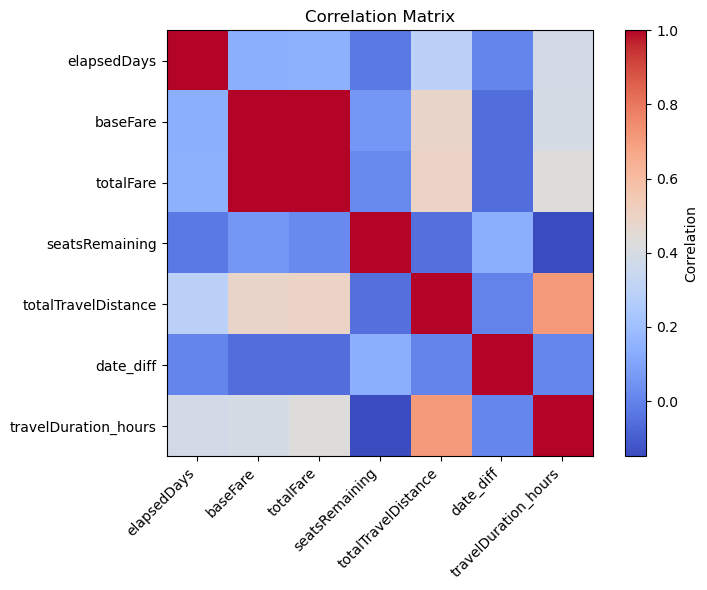

In [182]:
import matplotlib.pyplot as plt
import pandas as pd


# Select only numeric columns
num_df = data.select_dtypes(include=['number'])
# remove segment columns for clarity
num_df = num_df[[col for col in num_df.columns if 'segment' not in col.lower()]]


# Compute correlation matrix
corr = num_df.corr()

# Display top correlations
print(corr)

# Visualize (Matplotlib heatmap only)
plt.figure(figsize=(8,6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [183]:
data = data.drop(columns = 'baseFare')

### Feature engineering steps

##### Scaling
##### Encoding
##### Binning
##### Transformations
##### Handling Outliers
##### Creation of Derived Variables

In [184]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [185]:
# ------- Scaling ------

num_col = data.select_dtypes(['int64', 'float64', 'Int64']).columns.tolist()

X = data[num_col]
y = data['totalFare']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 2025)


In [186]:
std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [187]:
# ------- Encoding ---------

cat_cols = [
    'startingAirport', 'destinationAirport',
    'segmentsArrivalAirportCode_1', 'segmentsArrivalAirportCode_2', 
    'segmentsArrivalAirportCode_3', 'segmentsArrivalAirportCode_4', 'segmentsArrivalAirportCode_5',
    'segmentsDepartureAirportCode_1', 'segmentsDepartureAirportCode_2',
    'segmentsDepartureAirportCode_3', 'segmentsDepartureAirportCode_4', 'segmentsDepartureAirportCode_5',
    'segmentsAirlineName_1', 'segmentsAirlineName_2', 'segmentsAirlineName_3', 
    'segmentsAirlineName_4', 'segmentsAirlineName_5',
    'segmentsCabinCode_1', 'segmentsCabinCode_2', 'segmentsCabinCode_3',
    'segmentsCabinCode_4', 'segmentsCabinCode_5'   
]
col_dummy = data[cat_cols]

eng_data = pd.get_dummies(col_dummy, drop_first=True)

eng_data.dtypes


startingAirport_BOS                  bool
startingAirport_CLT                  bool
startingAirport_DEN                  bool
startingAirport_DFW                  bool
startingAirport_DTW                  bool
                                     ... 
segmentsCabinCode_3_coach            bool
segmentsCabinCode_3_first            bool
segmentsCabinCode_3_premium coach    bool
segmentsCabinCode_4_first            bool
segmentsCabinCode_4_premium coach    bool
Length: 722, dtype: object

In [ ]:
# ------ Bining ----------

def bin_columns(df):
    
    df['seatsRemaining_bin'] = pd.cut(df['seatsRemaining'], bins=[-1, 2, 5, 10], labels=['1-2', '3-5', '6-10'])
    
    df['travelDuration_hours_bin'] = pd.cut(df['travelDuration_hours'],
                                            bins=[-1, 3, 6, 12, float('inf')],
                                            labels=['<3h', '3-6h', '6-12h', '>12h'])
    
    df['totalTravelDistance_bin'] = pd.cut(df['totalTravelDistance'],
                                           bins=[-1, 500, 1000, 2000, float('inf')],
                                           labels=['<500', '500-1000', '1000-2000', '2000+'])
    
    return df

bin_columns(data)

,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,elapsedDays,isBasicEconomy,isRefundable,isNonStop,...,travelDuration_hours,elapsedDays_bin,seatsRemaining_bin,travelDuration_hours_bin,totalTravelDistance_bin,log_totalFare,log_travelDuration_hours,log_segmentsDistance_1,log_segmentsDistance_2,log_segmentsDurationInSeconds_1
1042959,476b78efd396326a49ab6c014062580d,2022-06-05,2022-06-08,BOS,OAK,QAA0OHEN,0.0,False,False,False,...,17.016667,0,6-20,>12h,2000+,6.721076,2.882004,6.759255,7.464510,9.230143
1437841,f51769cb2653b33e5cfa08c03f807e60,2022-06-23,2022-06-29,DFW,DTW,KA7NA0MQ,0.0,False,False,True,...,2.683333,0,6-20,<3h,500-1000,5.939118,0.987060,6.902743,6.579251,9.175749
1067453,70a386ff829092750869136b4c710568,2022-06-08,2022-06-14,LAX,CLT,KH0OAVMN,0.0,False,False,False,...,10.983333,0,1-5,6-12h,2000+,6.554076,2.396379,7.119636,6.698268,9.314700
198386,15a2d8dc5cb7b3ec0210f1f87adcbade,2022-04-23,2022-06-12,IAD,LAX,QAA4OFEN,0.0,False,False,False,...,14.833333,0,6-20,>12h,2000+,6.441265,2.696877,5.398163,7.807103,8.438150
2674967,5a26f39498d66b0836491c0aebb4f080,2022-08-07,2022-09-06,JFK,DEN,KAVOA0MQ,0.0,False,False,False,...,8.716667,0,6-20,6-12h,1000-2000,6.399593,2.165237,5.398163,7.295056,8.548692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2792471,9c1ff52aaefd7a4f5065c233af3ff578,2022-08-10,2022-09-04,PHL,SFO,NUAGZNN1,0.0,False,False,False,...,8.066667,0,1-5,6-12h,2000+,5.511815,2.087740,7.636270,6.480045,9.811372
39596,97dec2c658314b0ae1a2e03645f02b48,2022-04-16,2022-04-25,ORD,ATL,V0AJZNN1,0.0,False,False,False,...,12.566667,1,6-20,>12h,1000-2000,5.746842,2.531048,6.579251,6.635947,8.954157
1117427,8e82871dddc6fcf81b70ca27f7ab95ff,2022-06-11,2022-07-04,LAX,BOS,QAA0AHEN,0.0,False,False,True,...,5.666667,1,6-20,3-6h,2000+,5.952204,1.734601,7.865572,6.579251,9.923290
3329802,dbef45b959930d0c94965df64b73bd30,2022-09-03,2022-10-04,PHL,DTW,NVAHZNB3,0.0,True,False,False,...,15.050000,0,6-20,>12h,1000-2000,5.255932,2.711378,5.634790,6.006353,8.616133


In [143]:
# ------ Transformations --------

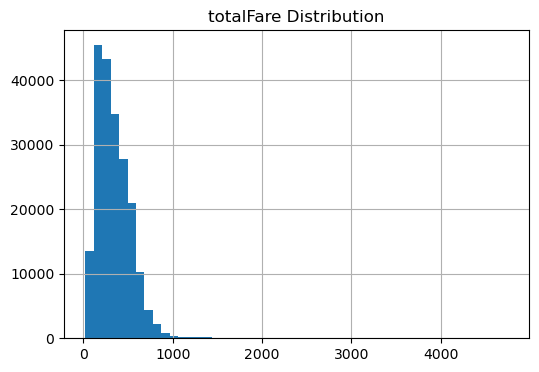

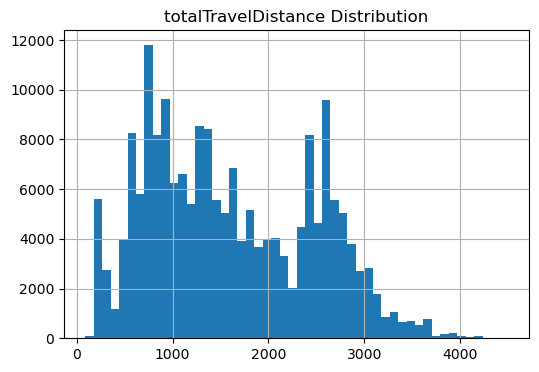

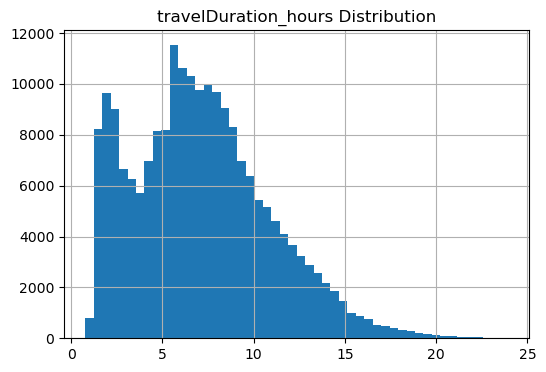

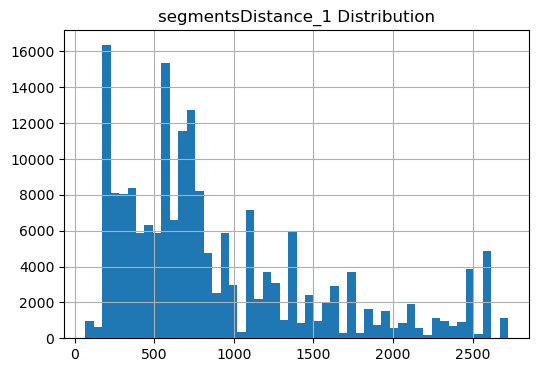

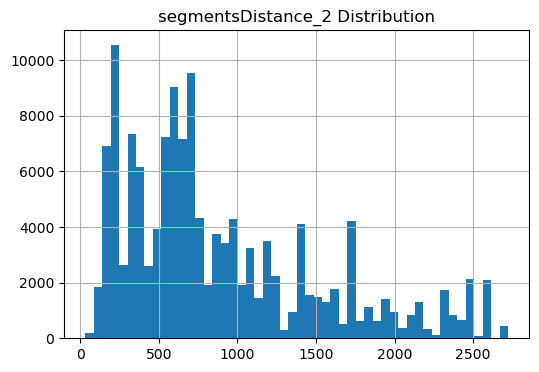

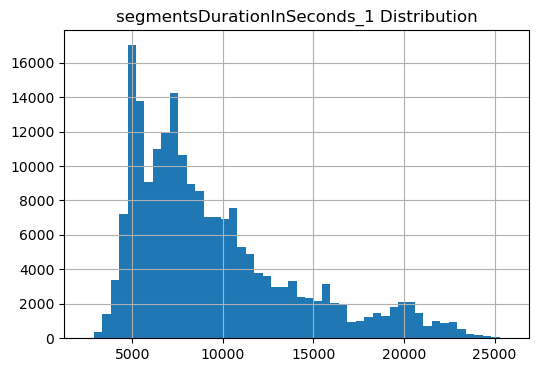

In [144]:
# ----- Checking for skewness of the numerical columns ------
num_cols = ['totalFare', 'totalTravelDistance', 'travelDuration_hours', 
            'segmentsDistance_1', 'segmentsDistance_2', 'segmentsDurationInSeconds_1']

# Plot histograms
for col in num_cols:
    plt.figure(figsize=(6,4))
    data[col].hist(bins=50)
    plt.title(f'{col} Distribution')
    plt.show()

In [114]:
# Checking if variables have 0 or negative values before applying log-transformations

log_cols = [
    'totalFare', 
    'travelDuration_hours', 
    'segmentsDistance_1', 
    'segmentsDistance_2', 
    'segmentsDurationInSeconds_1'
]

# Check for zeros or negatives
for col in log_cols:
    min_val = data[col].min()
    num_nonpositive = (data[col] <= 0).sum()
    print(f"{col}: min = {min_val}, non-positive values = {num_nonpositive}")

totalFare: min = 19.59, non-positive values = 0
travelDuration_hours: min = 0.7666666666666667, non-positive values = 0
segmentsDistance_1: min = 67, non-positive values = 0
segmentsDistance_2: min = 31, non-positive values = 0
segmentsDurationInSeconds_1: min = 2400, non-positive values = 0


In [154]:
original_cols = ['totalFare', 'travelDuration_hours', 'segmentsDistance_1', 'segmentsDistance_2', 'segmentsDurationInSeconds_1']
print(data[original_cols].isna().sum())


totalFare                      0
travelDuration_hours           0
segmentsDistance_1             0
segmentsDistance_2             0
segmentsDurationInSeconds_1    0
dtype: int64


In [148]:
# filling the remaining NA values before

for col in ['travelDuration_hours', 'segmentsDistance_1', 'segmentsDistance_2']:
    median_val = data[col].median()
    data[col].fillna(median_val, inplace=True)


/var/folders/23/8rs30vhx2l77dtdgxd1972nc0000gn/T/ipykernel_55661/766224143.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(median_val, inplace=True)
/var/folders/23/8rs30vhx2l77dtdgxd1972nc0000gn/T/ipykernel_55661/766224143.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

In [ ]:
# ----- Log-Transformations --------

for col in log_cols:
    data[col] = data[col].astype(float)  
    data[f'log_{col}'] = np.log(data[col])  

print(data[[f'log_{col}' for col in log_cols]].head())


         log_totalFare  log_travelDuration_hours  log_segmentsDistance_1  \
1042959       6.721076                  2.882004                6.759255   
1437841       5.939118                  0.987060                6.902743   
1067453       6.554076                  2.396379                7.119636   
198386        6.441265                  2.696877                5.398163   
2674967       6.399593                  2.165237                5.398163   

         log_segmentsDistance_2  log_segmentsDurationInSeconds_1  
1042959                7.464510                         9.230143  
1437841                6.579251                         9.175749  
1067453                6.698268                         9.314700  
198386                 7.807103                         8.438150  
2674967                7.295056                         8.548692  


In [157]:
# ----- Continue to fill the NA values with median -----
na_cols = ['totalTravelDistance', 
           'segmentsDurationInSeconds_2', 'segmentsDurationInSeconds_3', 
           'segmentsDurationInSeconds_4', 'segmentsDurationInSeconds_5',
           'segmentsDistance_3', 'segmentsDistance_4', 'segmentsDistance_5']

for col in na_cols:
    data[col] = data[col].astype(float)        # convert to float
    median_val = data[col].median()            # compute median
    data[col] = data[col].fillna(median_val)  # fill NaNs


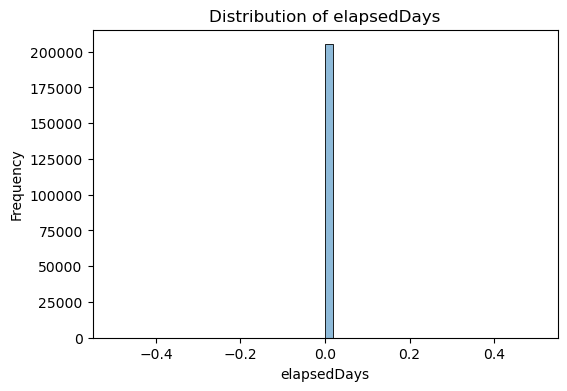

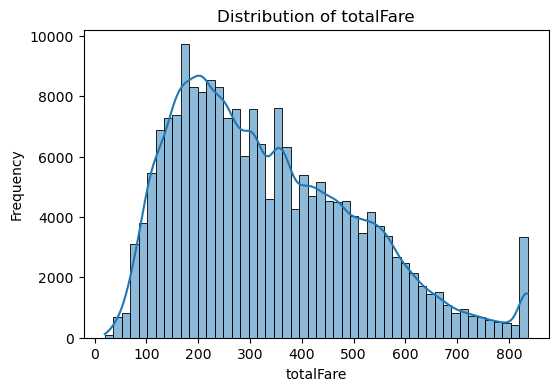

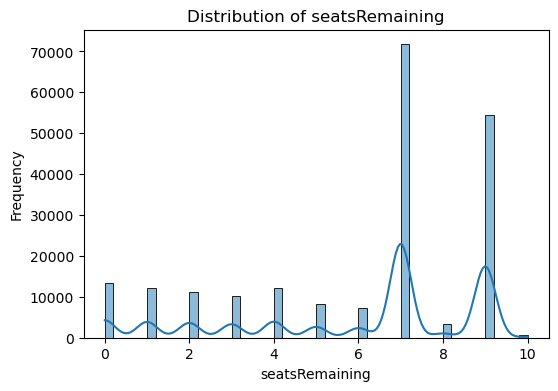

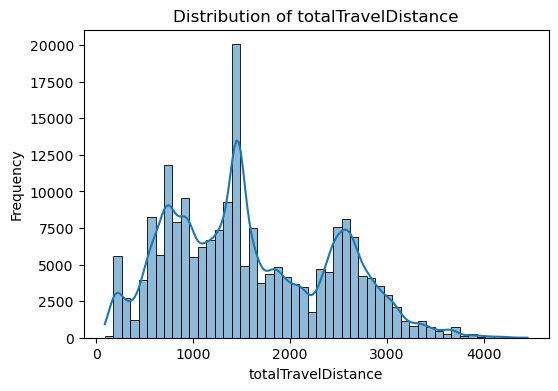

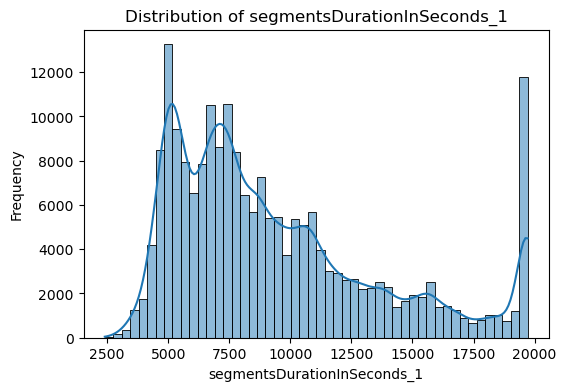

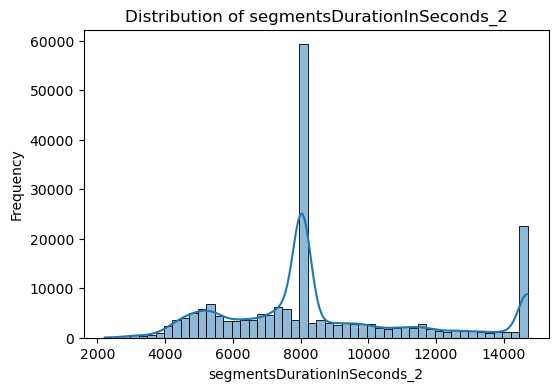

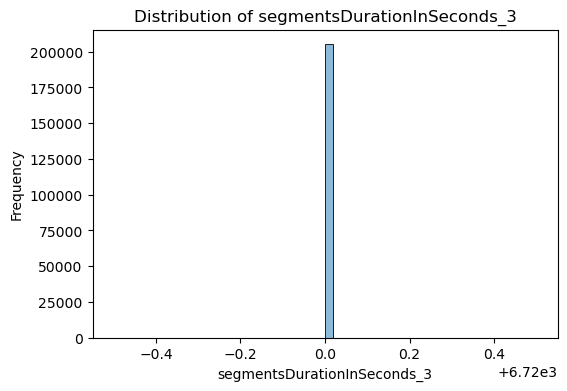

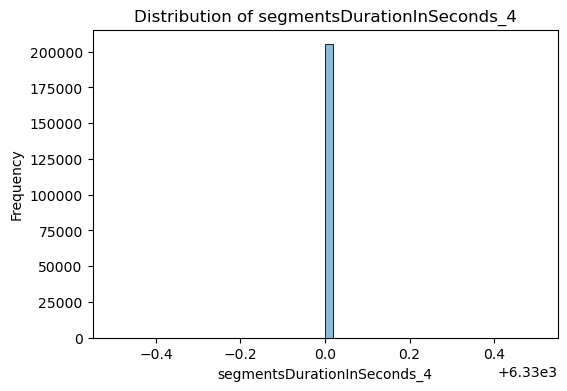

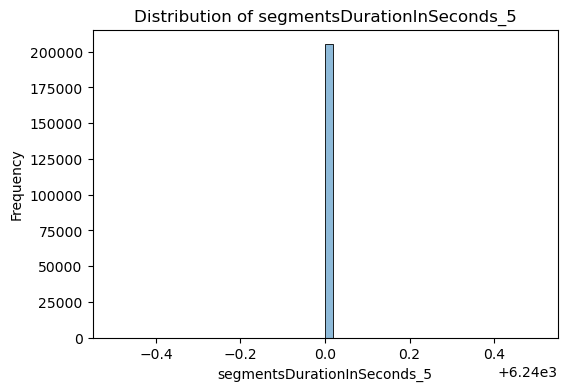

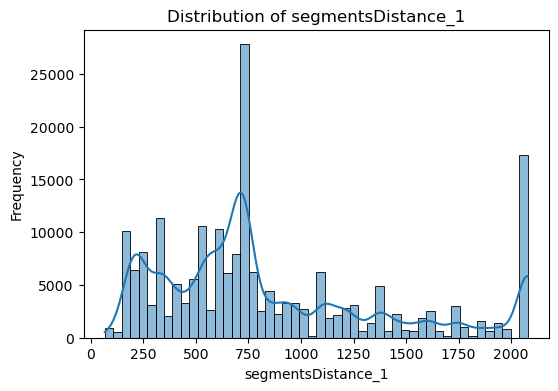

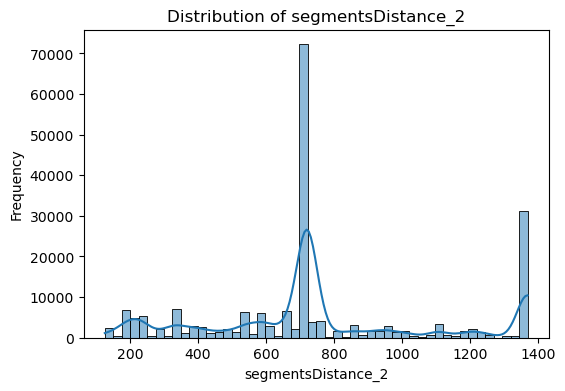

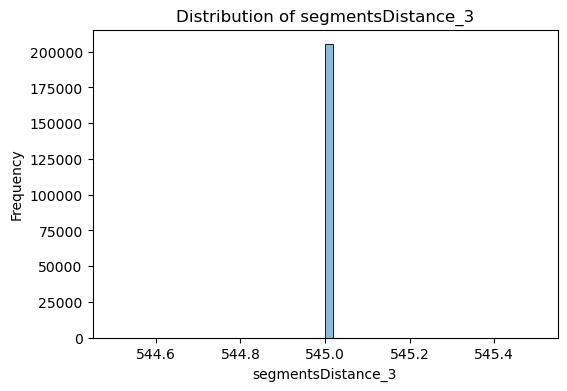

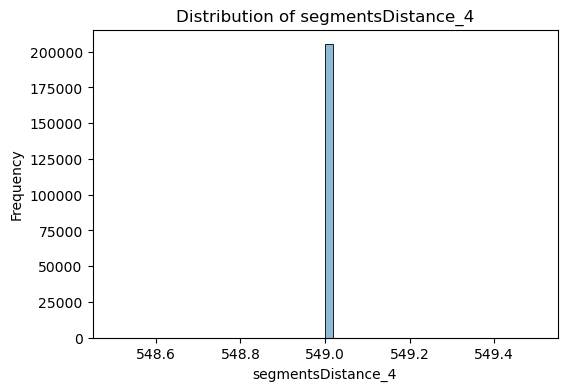

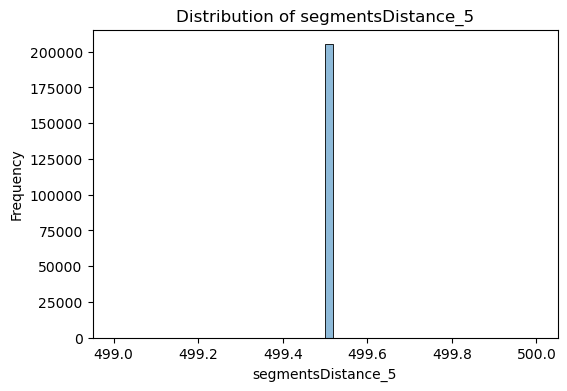

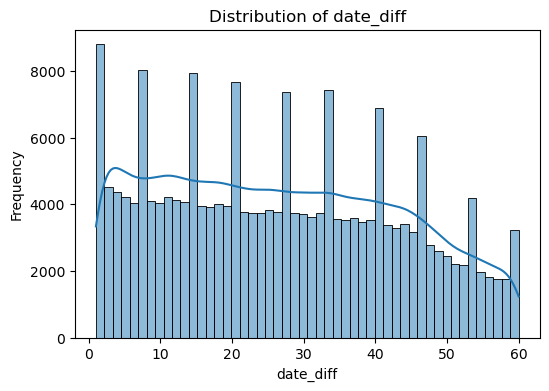

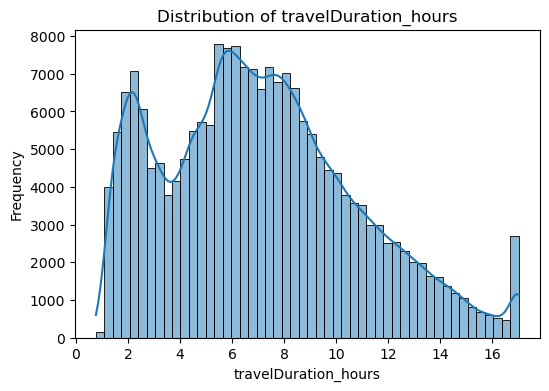

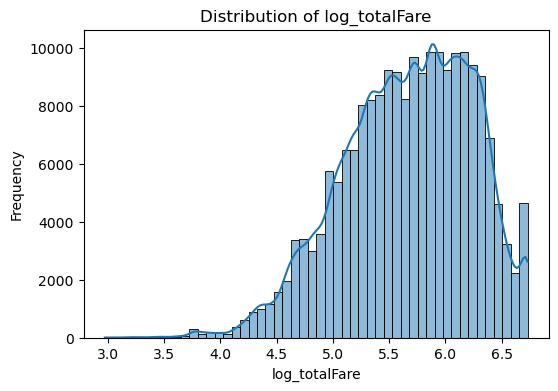

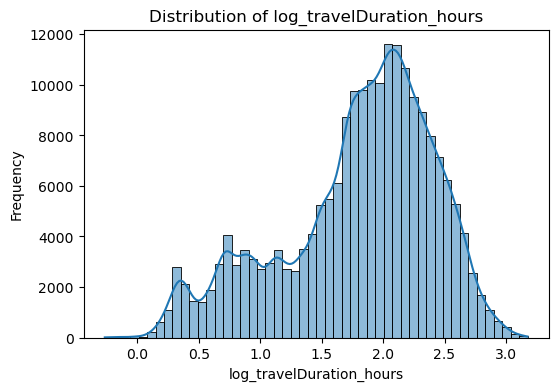

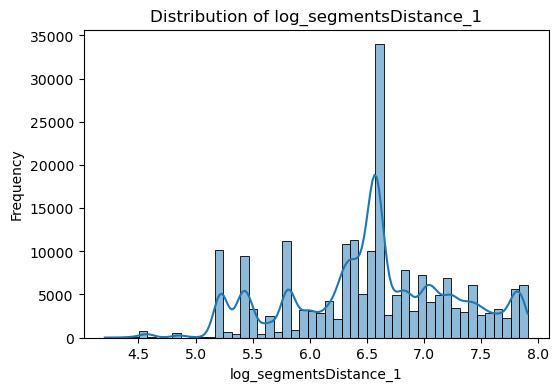

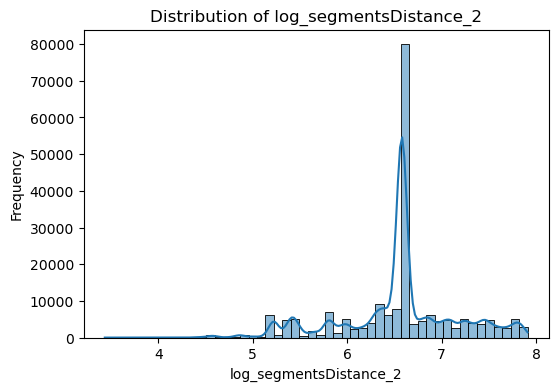

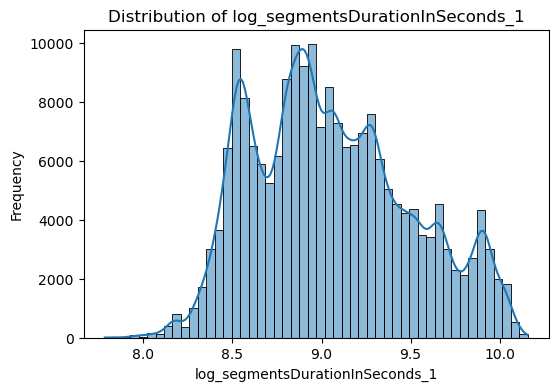

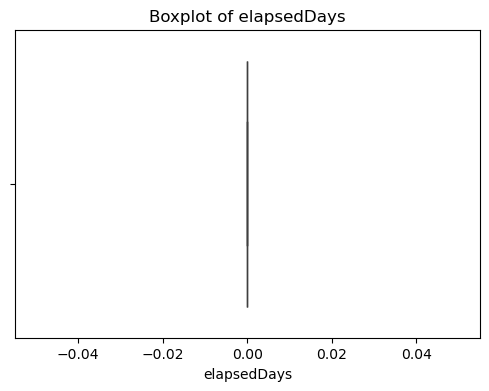

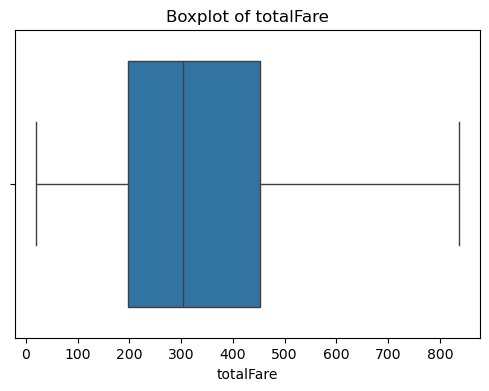

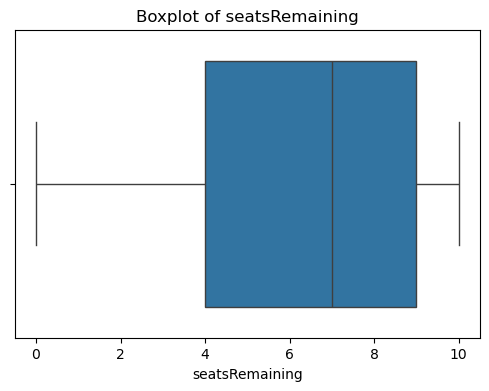

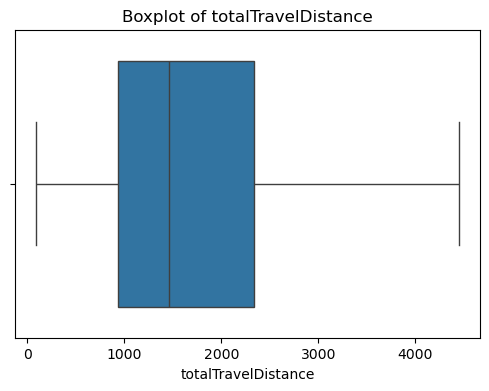

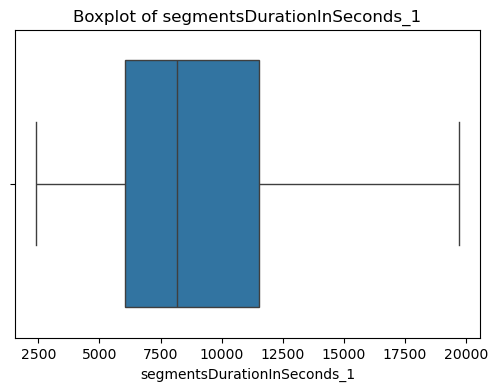

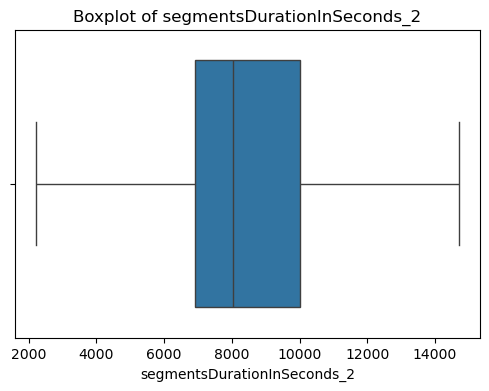

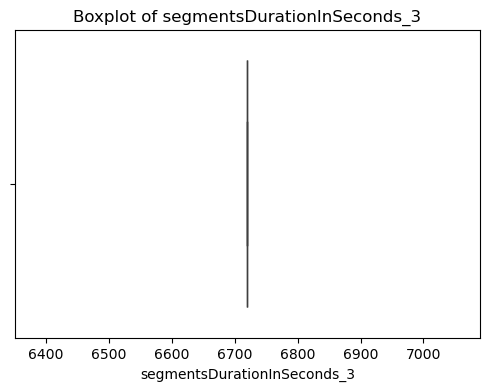

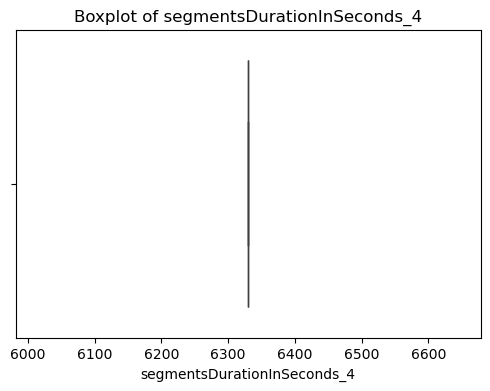

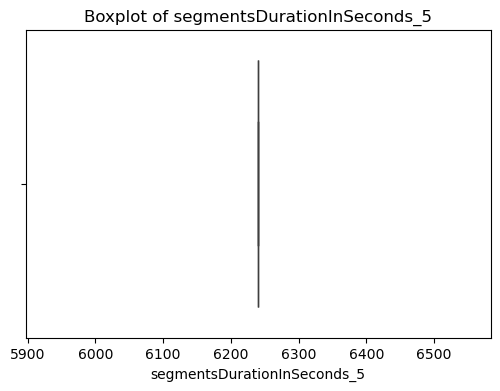

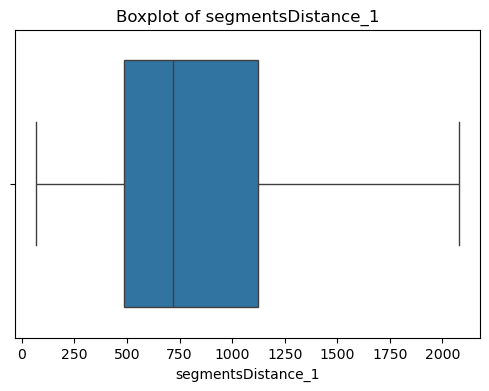

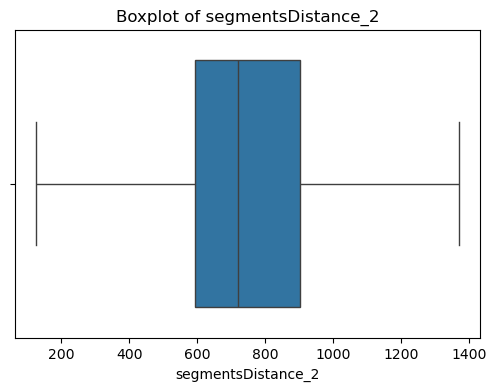

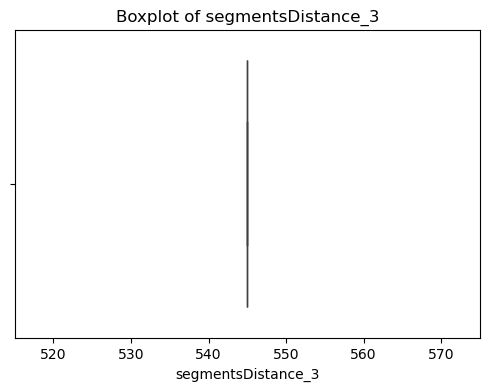

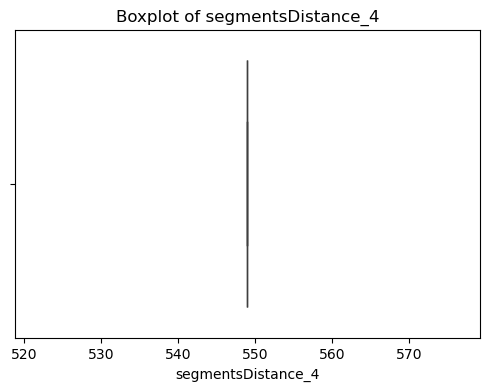

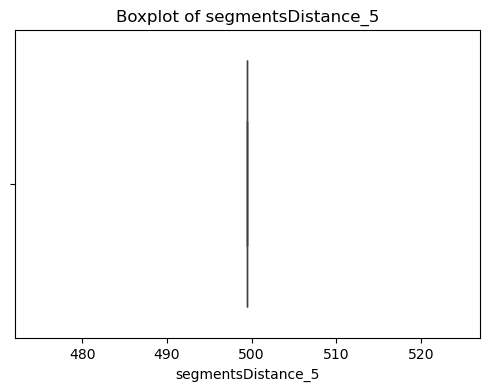

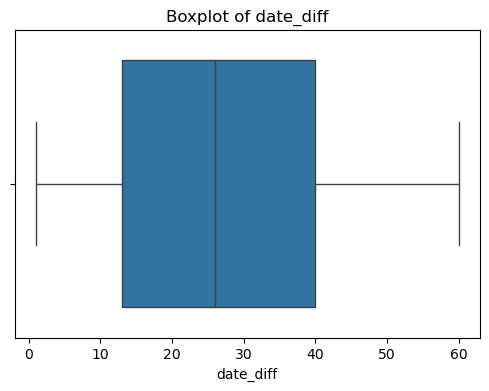

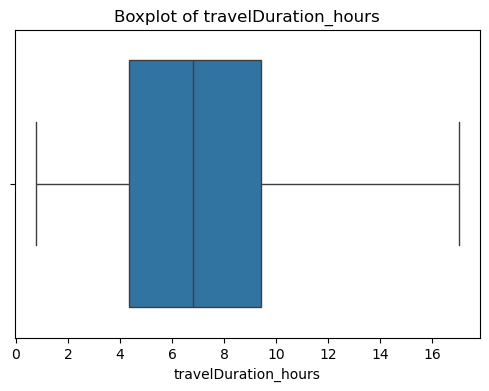

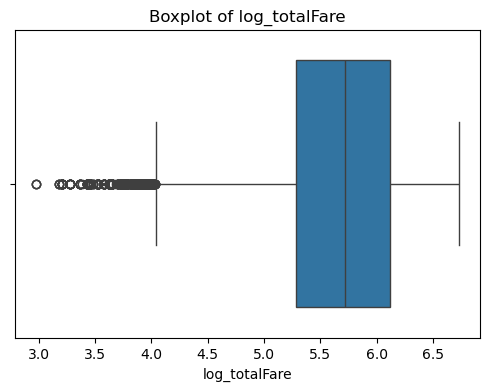

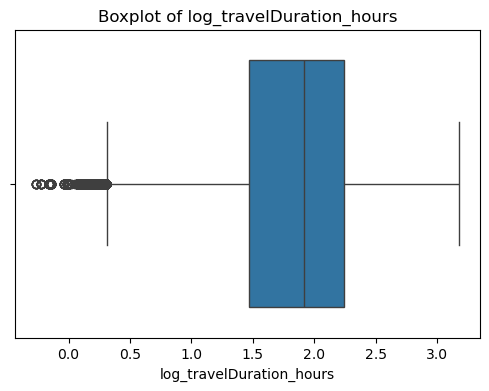

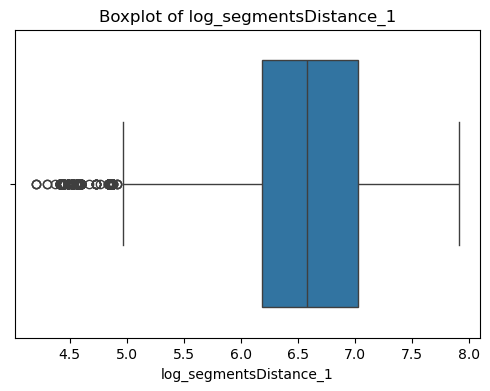

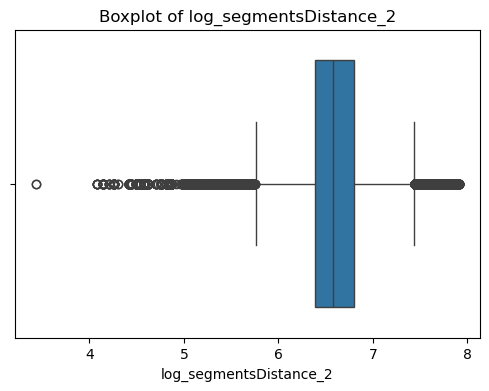

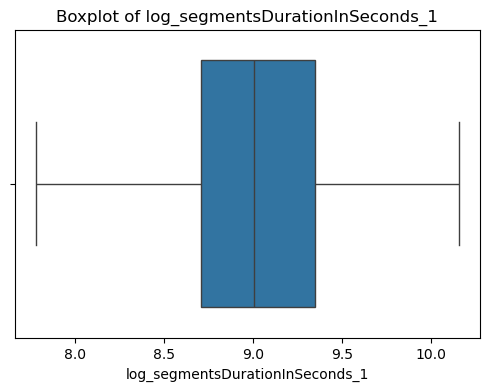

In [ ]:
# -------- Handling Outliers ----------

# For integers 

num_col = data.select_dtypes(['int64', 'float64', 'Int64']).columns.tolist()

# Plot histograms for all numerical columns
for col in num_col:
    plt.figure(figsize=(6,4))
    sns.histplot(data[col], bins=50, kde=True)  # histogram + density
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Optional: Boxplots to see outliers clearly
for col in num_col:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


In [ ]:
# for categorical variables
threshold = 0.10  
n_rows = len(data)

for col in cat_cols_to_encode:
    freq = data[col].value_counts() / n_rows
    rare_categories = freq[freq < threshold]
    
    if len(rare_categories) > 0:
        print(f"{col}: {list(rare_categories.index)}")


startingAirport: ['LAX', 'LGA', 'BOS', 'DFW', 'SFO', 'ORD', 'CLT', 'ATL', 'MIA', 'PHL', 'DEN', 'DTW', 'JFK', 'EWR', 'OAK', 'IAD']
destinationAirport: ['LAX', 'LGA', 'DFW', 'BOS', 'ORD', 'SFO', 'CLT', 'ATL', 'MIA', 'PHL', 'DEN', 'DTW', 'JFK', 'EWR', 'OAK', 'IAD']
segmentsArrivalAirportCode_1: ['ORD', 'ATL', 'CLT', 'BOS', 'JFK', 'DFW', 'LAX', 'EWR', 'LGA', 'DEN', 'IAD', 'DTW', 'IAH', 'SEA', 'DCA', 'MIA', 'SLC', 'SFO', 'LAS', 'MCO', 'MSP', 'PHX', 'PHL', 'FLL', 'AUS', 'RDU', 'BNA', 'PDX', 'PIT', 'CLE', 'BWI', 'TPA', 'MYR', 'RIC', 'ONT', 'ORF', 'STL', 'CHS', 'JAX', 'ROC', 'MSY', 'CMH', 'SYR', 'BTV', 'OAK', 'PWM', 'MEM', 'MCI', 'SAV', 'CVG', 'SAN', 'IND', 'DAL', 'GSO', 'BOI', 'SAT', 'ABQ', 'CHO', 'DUJ', 'GEG', 'SNA', 'BHM', 'UIN', 'RSW', 'ROA', 'SLK', 'BZN', 'TTN', 'LNS', 'MSS', 'LIT', 'BUF', 'LEX', 'HSV', 'TUL', 'TUS', 'SHV', 'CEZ', 'OKC', 'XNA', 'PBI', 'GSP', 'SDF', 'ELP', 'SBA', 'TEX', 'SMF', 'MDT', 'AVL', 'HPN', 'TYS', 'BDL', 'DAY', 'PNS', 'ACK', 'CVN', 'MGW', 'BJC', 'MFR', 'PVD', 'CHA',